# Semi-supervised learning with a Graph-convolutional network

We test the GCN approach ([Kipf & Welling, 2016, “Semi-Supervised Classification with Graph Convolutional Networks”](http://arxiv.org/abs/1609.02907)) on random graphs and create a visualisation to understand what is going on.

You can jump directly to [Test random graphs](#Test-random-graphs), the rest is setup and viz code.

### Setup and imports

In [1]:
import time
import itertools

import numpy as np
import scipy as sp
import scipy.stats
import tensorflow as tf
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.patches import Wedge, Circle
from matplotlib.text import Text
%matplotlib inline
import seaborn as sb
from IPython.display import HTML, display

from gcn.models import GCN
from gcn import utils as gcn_utils

#mpl.rc('animation', embed_limit=50 * 1024 * 1024) # In bytes; default limit in 20MB
VID = 'animations/l={l}-k={k}-p_inner={p_inner}-p_outer={p_outer}-f_mult={f_mult}-f_sigma={f_sigma}.mp4'

### Network drawing routines

In [2]:
BORDER_PROP = .2
RADIUS_GAP = .2
THETA_GAP = .05

def inner_repeat(it, n):
    return itertools.chain(*zip(*itertools.tee(it, n)))

def nodes_patches(layout, labels, training_nodes=[], radius=.04):
    titles, xys = zip(*sorted(layout.items()))
    
    # Preprocess labels
    labels = np.array(labels) + 1e-6
    assert len(labels.shape) == 2
    labels /= labels.sum(1)[:, np.newaxis]
    palette_border = np.array(sb.color_palette(n_colors=labels.shape[1]))
    palette_circle = np.array(sb.color_palette(n_colors=labels.shape[1]))

    # Create wedges
    wedges = []
    # Scale thetas to leave space for the gaps
    thetas2 = labels.cumsum(1) * (1 - THETA_GAP * labels.shape[1])
    thetas1 = np.concatenate([np.zeros((labels.shape[0], 1)), thetas2[:, :-1]], axis=1)
    # Shift thetas to get the gaps
    thetas2 = thetas2 + np.arange(labels.shape[1]) * THETA_GAP
    thetas1 = thetas1 + np.arange(labels.shape[1]) * THETA_GAP
    for i, (xy, theta1, theta2) in enumerate(zip(inner_repeat(xys, labels.shape[1]),
                                                 thetas1.flat, thetas2.flat)):
        wedges.append(Wedge(xy, radius,
                            theta1 * 360, theta2 * 360,
                            width=BORDER_PROP * radius,
                            color=palette_border[i % labels.shape[1]]))
    
    # Create central circles and titles
    circles = []
    texts = []
    color_predictions = palette_circle[np.argmax(labels, axis=1)]
    color_predictions[training_nodes] = [0, 0, 0]
    for xy, color, title in zip(xys, color_predictions, titles):
        circles.append(Circle(xy, radius * (1 - BORDER_PROP - RADIUS_GAP), color=color))
        texts.append(Text(x=xy[0], y=xy[1], text=str(title),
                          va='center', ha='center',
                          color='white', # if np.mean(color) >= .5 else 'black',
                          #fontsize=radius * 100)
                          ))
    
    return wedges + circles, texts

def update_nodes_patches(patches, labels, training_nodes=[]):
    # Preprocess labels
    labels = np.array(labels) + 1e-6
    assert len(labels.shape) == 2
    labels /= labels.sum(1)[:, np.newaxis]
    palette = np.array(sb.color_palette(n_colors=labels.shape[1]))
    
    # Extract wedges and circles
    wedges = list(filter(lambda p: isinstance(p, Wedge), patches))
    assert len(wedges) == np.prod(labels.shape)
    circles = list(filter(lambda p: isinstance(p, Circle), patches))
    assert len(circles) == labels.shape[0]
    
    # Update wedges
    # Scale thetas to leave space for the gaps
    thetas2 = labels.cumsum(1) * (1 - THETA_GAP * labels.shape[1])
    thetas1 = np.concatenate([np.zeros((labels.shape[0], 1)), thetas2[:, :-1]], axis=1)
    # Shift thetas to get the gaps
    thetas2 = thetas2 + np.arange(labels.shape[1]) * THETA_GAP
    thetas1 = thetas1 + np.arange(labels.shape[1]) * THETA_GAP
    for theta1, theta2, wedge in zip(thetas1.flat, thetas2.flat, wedges):
        wedge.set_theta1(theta1 * 360)
        wedge.set_theta2(theta2 * 360)
    
    # Update circles
    color_predictions = palette[np.argmax(labels, axis=1)]
    color_predictions[training_nodes] = [0, 0, 0]
    for circle, color in zip(circles, color_predictions):
        circle.set_color(color)

_network_layouts = {}
def draw_network(g, labels=None, training_nodes=[], ax=None, relayout=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.figure
    
    if relayout or g not in _network_layouts:
        _network_layouts[g] = nx.drawing.layout.spring_layout(g)
    layout = _network_layouts[g]
    
    if labels is None:
        assert len(training_nodes) == 0
        nx.draw_networkx(g, pos=layout, ax=ax, node_color='#65cb5e')
        node_patches = None
        edge_collection = None
        text_items = None
    else:
        # Plot nodes, edges and labels
        node_patches, text_items = nodes_patches(layout, labels, training_nodes=training_nodes)
        for artist in itertools.chain(node_patches, text_items):
            ax.add_artist(artist)
        edge_collection = nx.draw_networkx_edges(g, pos=layout, edge_color='grey', ax=ax)
        
        # Add the colorbar
        #color_sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=lmin, vmax=lmax))
        #color_sm.set_array([])
        #fig.colorbar(color_sm)
    
    xs, ys = np.array(list(layout.values())).T
    ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), aspect='equal')
    return (fig, ax), (node_patches, edge_collection, text_items)

### Try out feature randomisation

In [3]:
def feature_sample(mode, scale=.2, size=None):
    #α = alpha
    #β = (α - 1) / mode - α + 2
    #return np.random.beta(α, β, size=size)
    return np.random.normal(mode, scale, size=size)

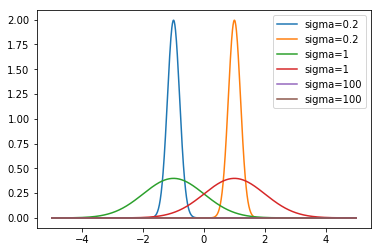

In [4]:
for sigma in [.2, 1, 100]:
    x = np.linspace(-5, 5, 1000)
    plt.plot(x, np.c_[scipy.stats.norm.pdf(x, -1, sigma), scipy.stats.norm.pdf(x, 1, sigma)],
             label='sigma={}'.format(sigma))
    #plt.hist(feature_sample(1, i, size=1000), normed=True, bins=50, alpha=.6)
plt.legend()

### GCN training setup

#### Initial setup

Base options for the model

In [5]:
flags = tf.app.flags
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0, #0.5,
                   'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0, #5e-4,
                   'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')

In [6]:
def initialise_arrays(labels, mult, sigma, training_nodes):
    # Generate initial noised features
    features_noise = np.stack([np.concatenate([feature_sample(v, scale=sigma, size=mult)
                                               for v in label_values])
                               for label_values in labels])
    features = gcn_utils.preprocess_features(sp.sparse.lil_matrix(features_noise))

    # Generate training and validation arrays
    train_mask = gcn_utils.sample_mask(training_nodes, labels.shape[0])
    val_mask = np.logical_not(train_mask)

    labels_train = np.zeros(labels.shape)
    labels_val = np.zeros(labels.shape)

    labels_train[train_mask, :] = labels[train_mask, :]
    labels_val[val_mask, :] = labels[val_mask, :]
    
    return {
        'features': features,
        'train_mask': train_mask,
        'val_mask': val_mask,
        'labels': labels,
        'labels_train': labels_train,
        'labels_val': labels_val,
    }

In [7]:
def initialise_model_session(g, labels, mult, sigma, training_nodes):
    arrays = initialise_arrays(labels, mult, sigma, training_nodes)
    
    # Finish parameterising the model
    support = [gcn_utils.preprocess_adj(nx.adjacency_matrix(g))]
    placeholders = {
        'support': [tf.sparse_placeholder(tf.float32) for _ in range(len(support))],
        'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(arrays['features'][2], dtype=tf.int64)),
        'labels': tf.placeholder(tf.float32, shape=(None, arrays['labels_train'].shape[1])),
        'labels_mask': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
        'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
    }
    arrays['support'] = support
    arrays['placeholders'] = placeholders
    
    model = GCN(placeholders, input_dim=arrays['features'][2][1], logging=True)
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    return model, arrays, session

In [8]:
def evaluate_model(model, arrays, session):
    t_test = time.time()
    feed_dict_val = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_val'], arrays['val_mask'],
                                                  arrays['placeholders'])
    outs_val = session.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

def model_predict(model, arrays, session):
    feed_dict_pred = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                   arrays['labels'], np.ones(arrays['labels'].shape[0]),
                                                   arrays['placeholders'])
    return session.run(model.predict(), feed_dict=feed_dict_pred)

#### Model training

In [9]:
def legend_text(epoch, t, train_loss, train_acc, val_loss, val_acc):
    return ("epoch: {:4d} time={:.5f}\n"
            "train_loss={:.5f} train_acc={:.5f}\n"
            "val_loss={:.5f} val_acc={:.5f}\n").format(epoch, time.time() - t,
                                                       train_loss, train_acc, val_loss, val_acc)

def model_weights(model, session):
    weights = []
    prod = np.eye(model.input_dim)
    
    for layer in model.layers:
        weights.append(layer.vars['weights_0'].eval(session=session).T)
        prod = weights[-1].dot(prod)
    
    return weights + [prod]

def build_train_animation(glk, labels, mult, sigma,
                          training_nodes=None, community_training_pct=.2,
                          log=True):
    if isinstance(glk, tuple):
        g, l, k = glk
    else:
        g = glk
    if training_nodes is None:
        trains_per_cty = int(np.round(k * community_training_pct))
        training_nodes = np.concatenate([np.random.choice(range(c * k, (c + 1) * k),
                                                          trains_per_cty, replace=False)
                                         for c in range(l)])
    
    # Get the model
    model, arrays, session = initialise_model_session(g, labels, mult, sigma, training_nodes)
    
    # Prepare figure
    fig = plt.figure(figsize=(20, 12))
    gs = plt.GridSpec(3, 5, hspace=.1)
    ax_g = plt.subplot(gs[:, :3])
    ax_l1 = plt.subplot(gs[0, 3:])
    ax_l1.set_title('Layer 1')
    ax_l2 = plt.subplot(gs[1, 3:])
    ax_l2.set_title('Layer 2')
    ax_l12 = plt.subplot(gs[2, 3:])
    ax_l12.set_title('Layer 2 * Layer 1')
    ax_g.set_axis_off()
    
    ## Plot the first frame
    # The graph
    _, (node_patches, _, _) = draw_network(g, labels=labels,
                                           training_nodes=np.where(arrays['train_mask'])[0],
                                           ax=ax_g)
    legend = ax_g.text(.5, 1, legend_text(0, 0, 0, 0, 0, 0),
                       ha='center', va='bottom',
                       transform=ax_g.transAxes,
                       bbox=dict(facecolor='white', alpha=0.8))
    # The layer weights
    weights1, weights2, weights12 = model_weights(model, session)
    im_l1 = ax_l1.imshow(weights1)
    im_l2 = ax_l2.imshow(weights2)
    im_l12 = ax_l12.imshow(weights12)
    # The colorbars
    cb_l1 = fig.colorbar(im_l1, ax=ax_l1)
    cb_l2 = fig.colorbar(im_l2, ax=ax_l2)
    cb_l12 = fig.colorbar(im_l12, ax=ax_l12)
    
    def init_plot():
        legend.set_text(legend_text(0, 0, 0, 0, 0, 0))
        return ()# node_patches + [legend, im_l1, im_l2, im_l12]#, cb_l1.ax, cb_l2.ax, cb_l12.ax]

    cost_val = []
    def train_step(frame):
        t = time.time()

        # Train one step further
        feed_dict = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_train'], arrays['train_mask'],
                                                  arrays['placeholders'])
        feed_dict.update({arrays['placeholders']['dropout']: flags.FLAGS.dropout})

        outs = session.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
        cost, acc, duration = evaluate_model(model, arrays, session)
        cost_val.append(cost)

        if log:
            print("Epoch:", '%04d' % (frame + 1), "train_loss={:.5f}".format(outs[1]),
                  "train_acc={:.5f}".format(outs[2]), "val_loss={:.5f}".format(cost),
                  "val_acc={:.5f}".format(acc), "time={:.5f}".format(time.time() - t))
        
        ## Plot the update
        # The graph
        preds = model_predict(model, arrays, session)
        update_nodes_patches(node_patches, preds, training_nodes=np.where(arrays['train_mask'])[0])
        legend.set_text(legend_text(frame, t, outs[1], outs[2], cost, acc))
        # The layer weights and colorbars
        weights1, weights2, weights12 = model_weights(model, session)
        im_l1.set_array(weights1)
        im_l1.set_clim(weights1.min(), weights1.max())
        im_l2.set_array(weights2)
        im_l2.set_clim(weights2.min(), weights2.max())
        im_l12.set_array(weights12)
        im_l12.set_clim(weights12.min(), weights12.max())

        return ()# node_patches + [legend, im_l1, im_l2, im_l12]#, cb_l1.ax, cb_l2.ax, cb_l12.ax]

    def model_frames():
        counter = 0
        while True:
            if (counter > flags.FLAGS.early_stopping and
                    cost_val[-1] > np.mean(cost_val[-(flags.FLAGS.early_stopping+1):-1])):
                if log:
                    print("Early stopping.")
                return
            else:
                yield counter
                counter += 1

    anim = mpl.animation.FuncAnimation(fig, train_step, blit=True,
                                       init_func=init_plot,
                                       interval=100,
                                       save_count=flags.FLAGS.epochs,
                                       frames=model_frames(),
                                       repeat=False)
    plt.close()
    return anim, (model, arrays, session)

### Test random graphs

We test the model on small random graphs to understand what's going on.

Each graph is created with a structure corresponding to $l$ communities (which appear more or less clearly). The "real" node labels are then $l$-dimensional vectors $Y$. E.g. for 3 communities, the label $Y_i$ for node $i$ can be `[1, 0, 0]` (community 0), `[0, 1, 0]` (community 1), `[0, 0, 1]` (community 2).

We then give node $i$ features $X_i$ which are a noisy version of the labels: $X_{i, j} \sim Y_{i, j} + \mathcal{N}(0, \sigma^2)$ for $j \in \{1, \dots, l\}$. The GCN takes the $X_i$ as input and learns to transform those; it is trained to mimick the $Y_i$ on a subset of the graph, i.e. it creates label predictions $Z_i = GCN(X_i)$ which should be as close to the $Y_i$ as possible. Note that $\sum_j Z_{i,j} = 1$, i.e. each coordinate of a predicted label is a probability of belonging to a community.

For each graph there are two or three cells:

* We first plot the "real" labels on which we train
* then we create an animation of the tranining process which is saved to an external file (and not shown in the notebook); the last line of the "train" cell indicates where the animation file is saved
* Sometimes we show individual predicted labels for specific nodes when useful

**Visualisation for a set of labels $Y_i$ or predictions $Z_i$:**

* Node color indicates the current inferred community of the node, defined as $\operatorname{argmax}_j Z_{i, j}$
* Node border color indicates the inferred probability of belonging to the "real" community, i.e. $Z_{i, \operatorname{argmax}_j Y_{i, j}}$
* Training nodes appear in black in the training animations


**Possible random graphs generators:**

* [Planted Partition](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.planted_partition_graph.html#networkx.generators.community.planted_partition_graph): all graphs below are made using this, or connecting two such graphs
* [Lancichinetti–Fortunato–Radicchi benchmark](https://en.wikipedia.org/wiki/Lancichinetti%E2%80%93Fortunato%E2%80%93Radicchi_benchmark) (we don't use this here)

#### Two large communites with an oddball in the middle, which we assign to a third community. Initial feature noise $\sigma = .2$

The animation shows first that since we don't train on the oddball, its community is not recovered at the end.

In fact, the weighing in the GCN is such that nodes that have fewer neighbours contribute *more* to their own neighbours' feature. At the time of writing (though this could change if we re-run the cell and get a different random graph), the oddball is connected to 4 nodes in each large communities; the green community should win because the green nodes that touch the oddball have fewer edges than the turquoise nodes touching the oddball, therefore their contribution is greater to the oddball's predicted label.

Running this animation several times on different random graphs confirms this intuition. Also note, in the cell below the training, the label prediction for the oddball node: it is not clear-cut, and instead reflects the slight preference for community 2 (green). Community 1 (the oddball community) is forgotten, with a probabiltiy of .006.

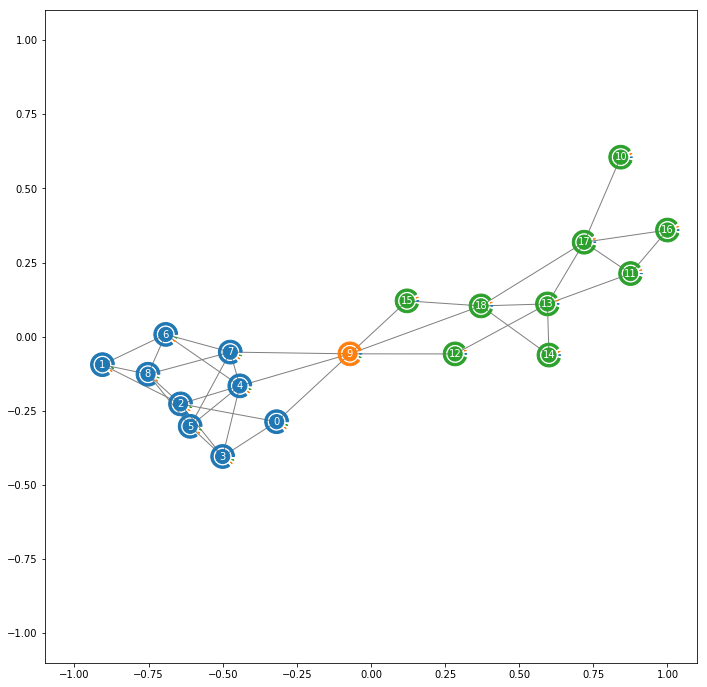

In [11]:
# Parameters
l1, l2, li = (10, 10, 1)
p_inner = .4
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 3))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 1] = 1
labels[l1:l1 + l2 - li, 2] = 1
draw_network(g, labels=labels);

In [12]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=labels.shape[1], p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.94613 train_acc=1.00000 val_loss=0.84976 val_acc=0.94118 time=0.02105
Epoch: 0002 train_loss=0.89642 train_acc=1.00000 val_loss=0.80220 val_acc=0.94118 time=0.00166
Epoch: 0003 train_loss=0.84770 train_acc=1.00000 val_loss=0.75710 val_acc=0.94118 time=0.00179
Epoch: 0004 train_loss=0.79957 train_acc=1.00000 val_loss=0.71453 val_acc=0.94118 time=0.00140
Epoch: 0005 train_loss=0.75253 train_acc=1.00000 val_loss=0.67449 val_acc=0.94118 time=0.00178
Epoch: 0006 train_loss=0.70668 train_acc=1.00000 val_loss=0.63690 val_acc=0.94118 time=0.00195
Epoch: 0007 train_loss=0.66208 train_acc=1.00000 val_loss=0.60173 val_acc=0.94118 time=0.00190
Epoch: 0008 train_loss=0.61884 train_acc=1.00000 val_loss=0.56911 val_acc=0.94118 time=0.00176
Epoch: 0009 train_loss=0.57705 train_acc=1.00000 val_loss=0.53900 val_acc=0.94118 time=0.00217
Epoch: 0010 train_loss=0.53679 train_acc=1.00000 val_loss=0.51128 val_acc=0.94118 time=0.00165
Epoch: 0011 train_loss=0.49812 train_acc=1.00000 v

#### Two communities that largely overlap, creating several oddballs in the middle which we assign to a third community; $\sigma = .2$

This is an extension of the previous graph to several oddballs, with training only on the main communities and not on the oddballs.

The reasoning is the same: the oddball community is lost since we don't train on it, and each oddball node acquires the label given by its neighbours with lowest degree (provided it has the same number of neighbours of each competing community, otherwise the community with most touching neighbours is likely to win).

The cell below the training shows the predictions for the oddballs, which confirm the intuitions.

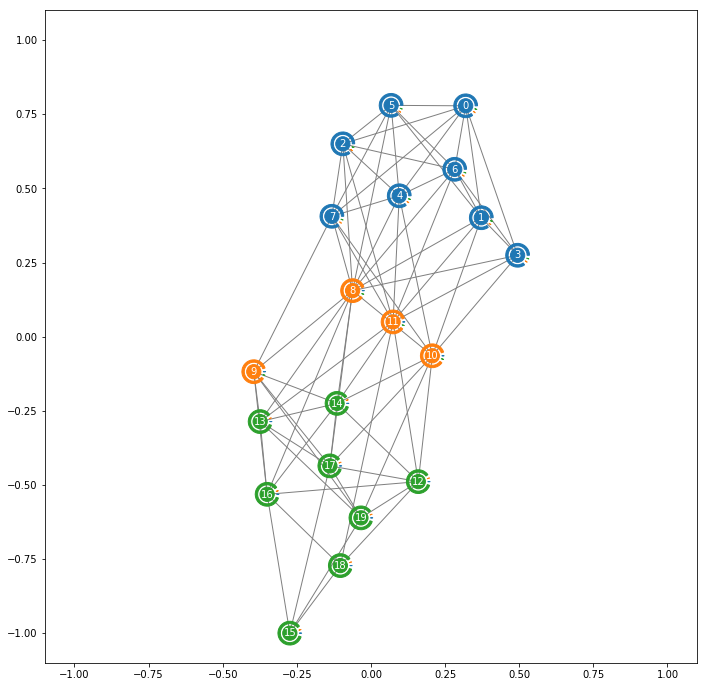

In [16]:
# Parameters
l1, l2, li = (12, 12, 4)
p_inner = .6
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 3))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 1] = 1
labels[l1:l1 + l2 - li, 2] = 1
draw_network(g, labels=labels);

In [17]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=labels.shape[1], p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.08919 train_acc=0.50000 val_loss=1.09867 val_acc=0.38889 time=0.02033
Epoch: 0002 train_loss=1.05707 train_acc=0.50000 val_loss=1.07840 val_acc=0.38889 time=0.00259
Epoch: 0003 train_loss=1.02559 train_acc=0.50000 val_loss=1.05885 val_acc=0.38889 time=0.00151
Epoch: 0004 train_loss=0.99468 train_acc=0.50000 val_loss=1.03994 val_acc=0.38889 time=0.00218
Epoch: 0005 train_loss=0.96434 train_acc=0.50000 val_loss=1.02183 val_acc=0.38889 time=0.00192
Epoch: 0006 train_loss=0.93455 train_acc=0.50000 val_loss=1.00459 val_acc=0.38889 time=0.00184
Epoch: 0007 train_loss=0.90534 train_acc=0.50000 val_loss=0.98824 val_acc=0.38889 time=0.00234
Epoch: 0008 train_loss=0.87674 train_acc=0.50000 val_loss=0.97274 val_acc=0.38889 time=0.00202
Epoch: 0009 train_loss=0.84862 train_acc=0.50000 val_loss=0.95812 val_acc=0.38889 time=0.00350
Epoch: 0010 train_loss=0.82113 train_acc=0.50000 val_loss=0.94441 val_acc=0.38889 time=0.00236
Epoch: 0011 train_loss=0.79419 train_acc=0.50000 v

#### Two communities that largely overlap, creating several oddballs in the middle which belong feature-wise to one or the other community; $\sigma = .2$

TODO: comment

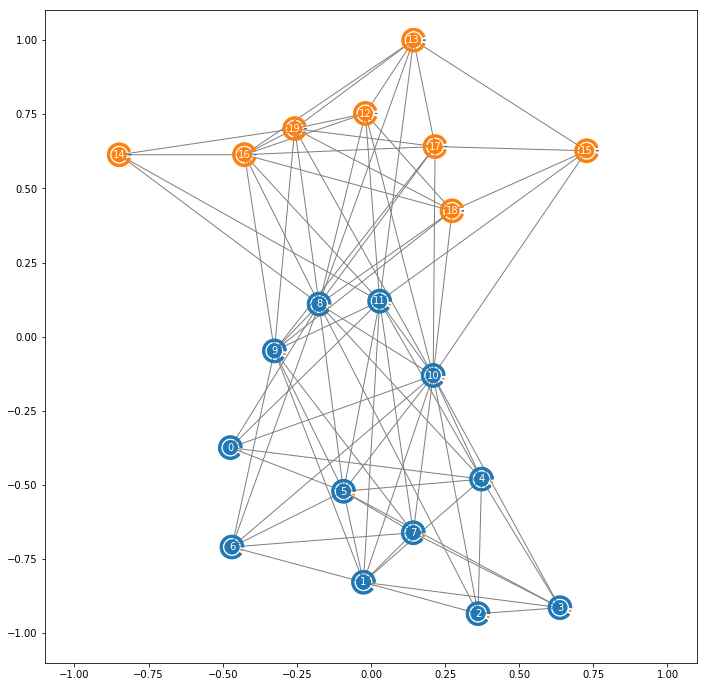

In [21]:
# Parameters
l1, l2, li = (12, 12, 4)
p_inner = .6
feature_mult = 1
feature_sigma = .2

# Show the graph
g1 = nx.planted_partition_graph(1, l1, p_inner, 0)
g2 = nx.relabel_nodes(nx.planted_partition_graph(1, l2, p_inner, 0),
                      {i: i + l1 - li for i in range(l2)})
g2.remove_edges_from(itertools.product(range(l1 - li, l1), repeat=2))
g = nx.compose(g1, g2)
labels = np.zeros((l1 + l2 - li, 2))
labels[:l1 - li, 0] = 1
labels[l1 - li:l1, 0] = 1
labels[l1:l1 + l2 - li, 1] = 1
draw_network(g, labels=labels);

In [22]:
# Training nodes
trains_per_cty = 1
training_nodes = np.concatenate([np.random.choice(range(l1 - li), trains_per_cty, replace=False),
                                 np.random.choice(range(l1, l1 + l2 - li), trains_per_cty, replace=False)])

# Animate training
filename = VID.format(l='{}|{}|{}'.format(l1, l2, li), k=labels.shape[1], p_inner=p_inner, p_outer=0,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation(g, labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.77610 train_acc=0.50000 val_loss=0.72766 val_acc=0.55556 time=0.02391
Epoch: 0002 train_loss=0.76277 train_acc=0.50000 val_loss=0.71881 val_acc=0.61111 time=0.00287
Epoch: 0003 train_loss=0.74991 train_acc=0.50000 val_loss=0.71054 val_acc=0.61111 time=0.00156
Epoch: 0004 train_loss=0.73757 train_acc=0.50000 val_loss=0.70273 val_acc=0.61111 time=0.00184
Epoch: 0005 train_loss=0.72570 train_acc=0.50000 val_loss=0.69541 val_acc=0.61111 time=0.00309
Epoch: 0006 train_loss=0.71433 train_acc=0.50000 val_loss=0.68848 val_acc=0.61111 time=0.00231
Epoch: 0007 train_loss=0.70340 train_acc=0.50000 val_loss=0.68178 val_acc=0.61111 time=0.00321
Epoch: 0008 train_loss=0.69279 train_acc=0.50000 val_loss=0.67513 val_acc=0.61111 time=0.00228
Epoch: 0009 train_loss=0.68238 train_acc=0.50000 val_loss=0.66836 val_acc=0.61111 time=0.00210
Epoch: 0010 train_loss=0.67201 train_acc=0.50000 val_loss=0.66135 val_acc=0.61111 time=0.00219
Epoch: 0011 train_loss=0.66164 train_acc=0.50000 v

Epoch: 0088 train_loss=0.02916 train_acc=1.00000 val_loss=0.14547 val_acc=0.94444 time=0.00149
Epoch: 0089 train_loss=0.02825 train_acc=1.00000 val_loss=0.14468 val_acc=0.94444 time=0.00147
Epoch: 0090 train_loss=0.02738 train_acc=1.00000 val_loss=0.14394 val_acc=0.94444 time=0.00188
Epoch: 0091 train_loss=0.02656 train_acc=1.00000 val_loss=0.14324 val_acc=0.94444 time=0.00158
Epoch: 0092 train_loss=0.02577 train_acc=1.00000 val_loss=0.14260 val_acc=0.94444 time=0.00181
Epoch: 0093 train_loss=0.02503 train_acc=1.00000 val_loss=0.14200 val_acc=0.94444 time=0.00188
Epoch: 0094 train_loss=0.02432 train_acc=1.00000 val_loss=0.14144 val_acc=0.94444 time=0.00183
Epoch: 0095 train_loss=0.02364 train_acc=1.00000 val_loss=0.14093 val_acc=0.94444 time=0.00215
Epoch: 0096 train_loss=0.02300 train_acc=1.00000 val_loss=0.14046 val_acc=0.94444 time=0.00185
Epoch: 0097 train_loss=0.02238 train_acc=1.00000 val_loss=0.14003 val_acc=0.94444 time=0.00252
Epoch: 0098 train_loss=0.02179 train_acc=1.00000 v

#### Two feature communities in a clique; $\sigma = .2$

TODO: comment

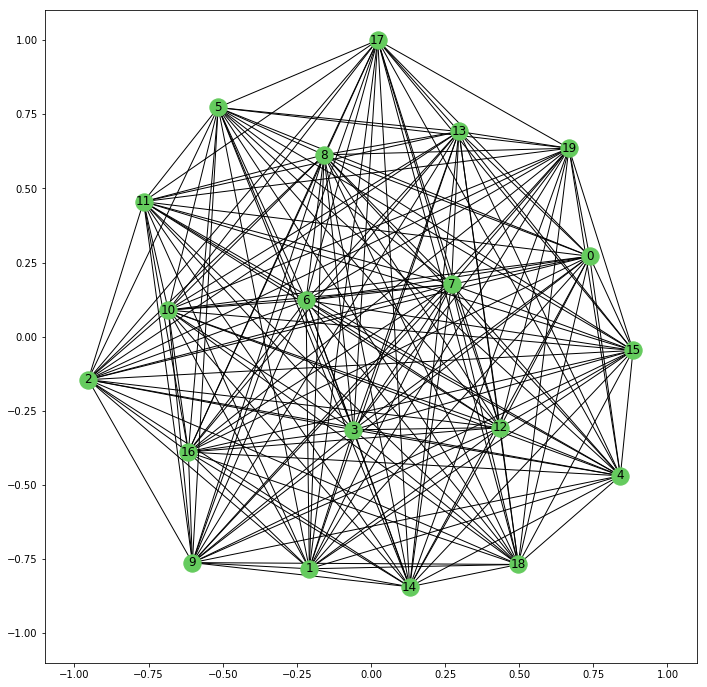

In [23]:
# Parameters
l = 1
k = 20
p_inner = 1
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
draw_network(g);

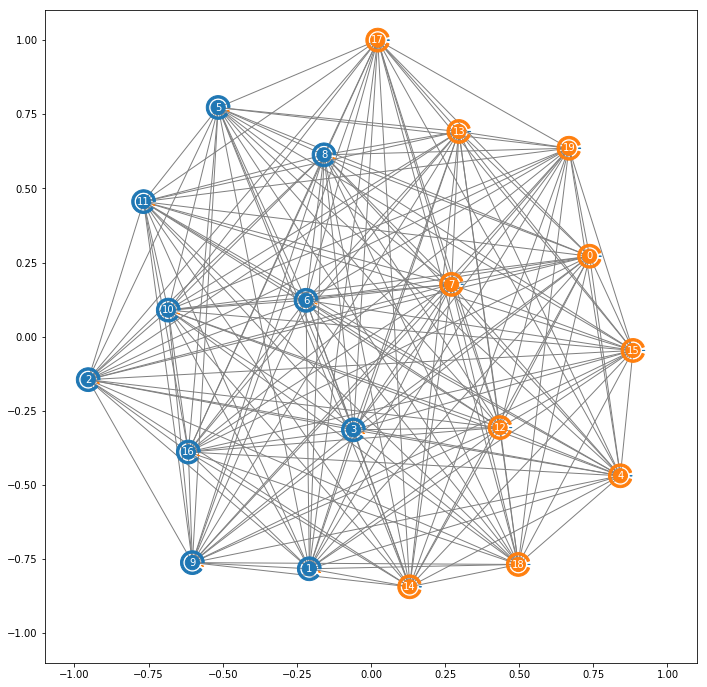

In [24]:
labels = np.zeros((l * k, 2))
c0 = [5, 11, 10, 2, 16, 9, 1, 8, 6, 3]
labels[c0, 0] = 1
labels[list(set(range(20)).difference(c0)), 1] = 1
draw_network(g, labels=labels);

In [25]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.75870 train_acc=0.50000 val_loss=0.74518 val_acc=0.50000 time=0.02576
Epoch: 0002 train_loss=0.74518 train_acc=0.50000 val_loss=0.73338 val_acc=0.50000 time=0.00175
Epoch: 0003 train_loss=0.73338 train_acc=0.50000 val_loss=0.72328 val_acc=0.50000 time=0.00200
Epoch: 0004 train_loss=0.72328 train_acc=0.50000 val_loss=0.71482 val_acc=0.50000 time=0.00189
Epoch: 0005 train_loss=0.71482 train_acc=0.50000 val_loss=0.70794 val_acc=0.50000 time=0.00336
Epoch: 0006 train_loss=0.70794 train_acc=0.50000 val_loss=0.70253 val_acc=0.50000 time=0.00189
Epoch: 0007 train_loss=0.70253 train_acc=0.50000 val_loss=0.69849 val_acc=0.50000 time=0.00199
Epoch: 0008 train_loss=0.69849 train_acc=0.50000 val_loss=0.69569 val_acc=0.50000 time=0.00325
Epoch: 0009 train_loss=0.69569 train_acc=0.50000 val_loss=0.69399 val_acc=0.50000 time=0.00275
Epoch: 0010 train_loss=0.69399 train_acc=0.50000 val_loss=0.69323 val_acc=0.50000 time=0.00178
Epoch: 0011 train_loss=0.69323 train_acc=0.50000 v

#### Two feature communities in a near-clique; $\sigma = .2$

TODO: comment

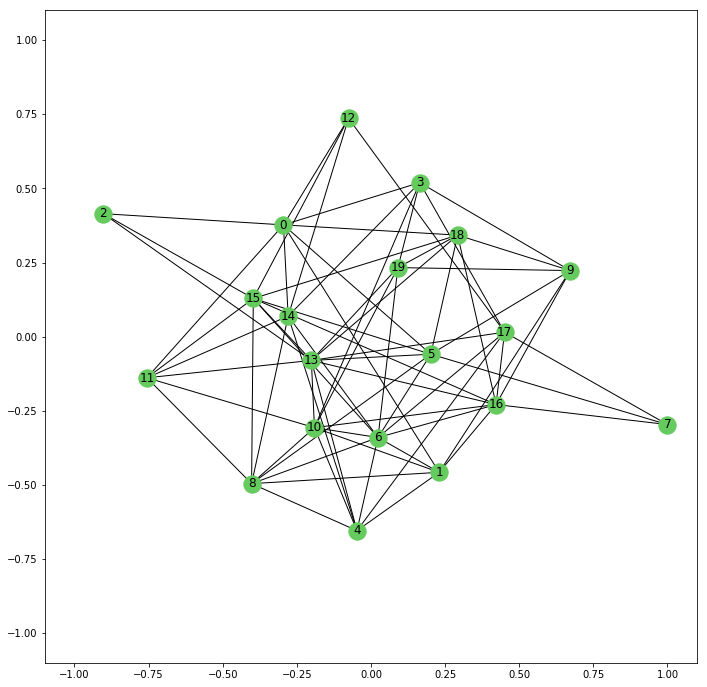

In [33]:
# Parameters
l = 1
k = 20
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
draw_network(g);

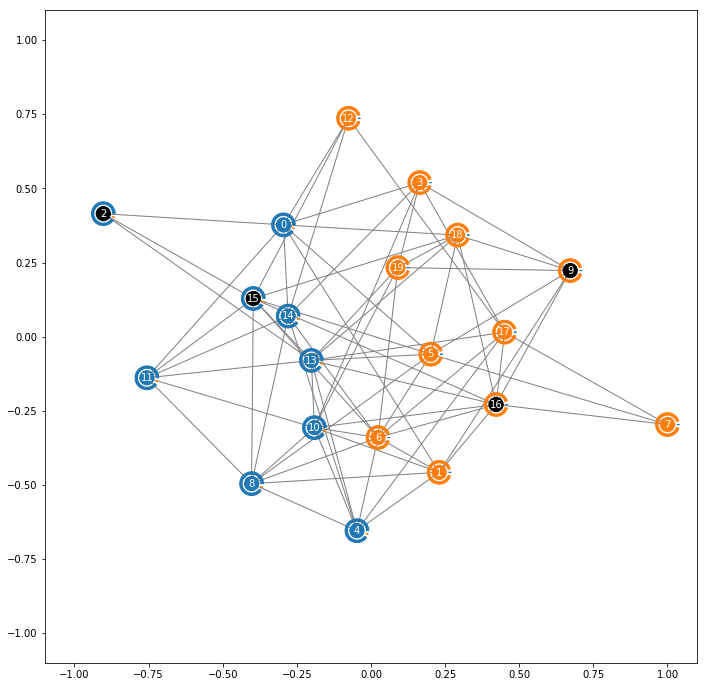

In [34]:
labels = np.zeros((l * k, 2))
c0 = [2, 11, 8, 15, 0, 14, 13, 10, 4]
training_nodes = [15, 2, 9, 16]
labels[c0, 0] = 1
labels[list(set(range(20)).difference(c0)), 1] = 1
draw_network(g, labels=labels, training_nodes=training_nodes);

In [35]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma,
                                                       training_nodes=training_nodes)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=0.62469 train_acc=1.00000 val_loss=0.63919 val_acc=0.87500 time=0.02956
Epoch: 0002 train_loss=0.61424 train_acc=1.00000 val_loss=0.63190 val_acc=0.87500 time=0.00836
Epoch: 0003 train_loss=0.60405 train_acc=1.00000 val_loss=0.62463 val_acc=0.81250 time=0.00221
Epoch: 0004 train_loss=0.59385 train_acc=1.00000 val_loss=0.61735 val_acc=0.81250 time=0.00649
Epoch: 0005 train_loss=0.58356 train_acc=1.00000 val_loss=0.61008 val_acc=0.81250 time=0.00264
Epoch: 0006 train_loss=0.57321 train_acc=1.00000 val_loss=0.60273 val_acc=0.81250 time=0.00657
Epoch: 0007 train_loss=0.56270 train_acc=1.00000 val_loss=0.59536 val_acc=0.81250 time=0.00300
Epoch: 0008 train_loss=0.55229 train_acc=1.00000 val_loss=0.58798 val_acc=0.87500 time=0.00427
Epoch: 0009 train_loss=0.54167 train_acc=1.00000 val_loss=0.58046 val_acc=0.87500 time=0.00495
Epoch: 0010 train_loss=0.53071 train_acc=1.00000 val_loss=0.57283 val_acc=0.87500 time=0.00147
Epoch: 0011 train_loss=0.51954 train_acc=1.00000 v

Epoch: 0088 train_loss=0.02946 train_acc=1.00000 val_loss=0.20375 val_acc=0.87500 time=0.00210
Epoch: 0089 train_loss=0.02867 train_acc=1.00000 val_loss=0.20295 val_acc=0.87500 time=0.00151
Epoch: 0090 train_loss=0.02791 train_acc=1.00000 val_loss=0.20218 val_acc=0.87500 time=0.00236
Epoch: 0091 train_loss=0.02719 train_acc=1.00000 val_loss=0.20144 val_acc=0.87500 time=0.00185
Epoch: 0092 train_loss=0.02649 train_acc=1.00000 val_loss=0.20072 val_acc=0.87500 time=0.00146
Epoch: 0093 train_loss=0.02583 train_acc=1.00000 val_loss=0.20003 val_acc=0.87500 time=0.00185
Epoch: 0094 train_loss=0.02519 train_acc=1.00000 val_loss=0.19935 val_acc=0.87500 time=0.00189
Epoch: 0095 train_loss=0.02457 train_acc=1.00000 val_loss=0.19869 val_acc=0.87500 time=0.00186
Epoch: 0096 train_loss=0.02398 train_acc=1.00000 val_loss=0.19804 val_acc=0.87500 time=0.00186
Epoch: 0097 train_loss=0.02342 train_acc=1.00000 val_loss=0.19739 val_acc=0.87500 time=0.00145
Epoch: 0098 train_loss=0.02287 train_acc=1.00000 v

Epoch: 0175 train_loss=0.00687 train_acc=1.00000 val_loss=0.17733 val_acc=0.87500 time=0.00145
Epoch: 0176 train_loss=0.00680 train_acc=1.00000 val_loss=0.17725 val_acc=0.87500 time=0.00147
Epoch: 0177 train_loss=0.00672 train_acc=1.00000 val_loss=0.17717 val_acc=0.87500 time=0.00148
Epoch: 0178 train_loss=0.00665 train_acc=1.00000 val_loss=0.17710 val_acc=0.87500 time=0.00148
Epoch: 0179 train_loss=0.00658 train_acc=1.00000 val_loss=0.17702 val_acc=0.87500 time=0.00155
Epoch: 0180 train_loss=0.00651 train_acc=1.00000 val_loss=0.17694 val_acc=0.87500 time=0.00321
Epoch: 0181 train_loss=0.00644 train_acc=1.00000 val_loss=0.17686 val_acc=0.87500 time=0.00143
Epoch: 0182 train_loss=0.00637 train_acc=1.00000 val_loss=0.17677 val_acc=0.87500 time=0.00193
Epoch: 0183 train_loss=0.00630 train_acc=1.00000 val_loss=0.17669 val_acc=0.87500 time=0.00400
Epoch: 0184 train_loss=0.00624 train_acc=1.00000 val_loss=0.17660 val_acc=0.87500 time=0.00344
Epoch: 0185 train_loss=0.00617 train_acc=1.00000 v

#### Four well-marked communities of size 10; $\sigma = .2$

In this case features and graph structure correspond to each other, with little noise in the initial features, and the GCN learns to predict labels perfectly.

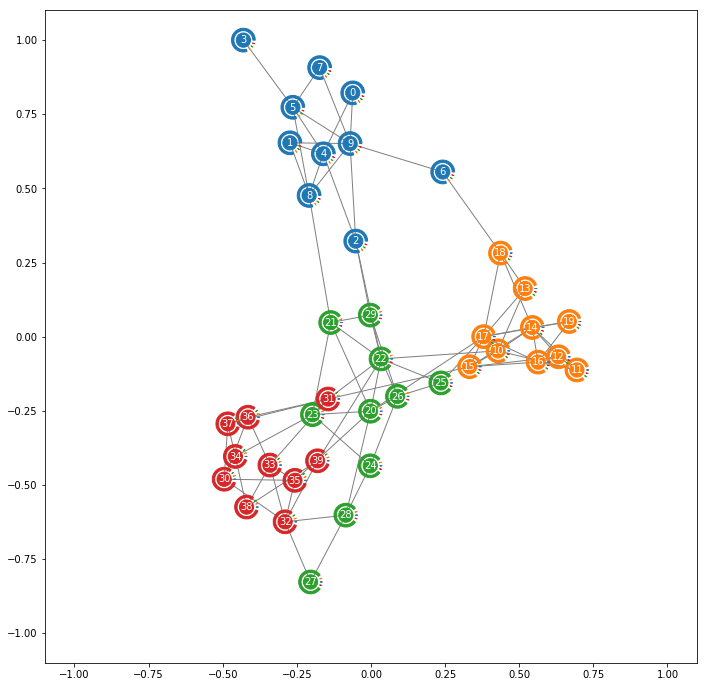

In [40]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [41]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.20980 train_acc=0.50000 val_loss=1.20342 val_acc=0.46875 time=0.03113
Epoch: 0002 train_loss=1.17894 train_acc=0.50000 val_loss=1.17772 val_acc=0.50000 time=0.00177
Epoch: 0003 train_loss=1.14834 train_acc=0.50000 val_loss=1.15226 val_acc=0.50000 time=0.00156
Epoch: 0004 train_loss=1.11814 train_acc=0.62500 val_loss=1.12668 val_acc=0.50000 time=0.00150
Epoch: 0005 train_loss=1.08811 train_acc=0.62500 val_loss=1.10143 val_acc=0.62500 time=0.00181
Epoch: 0006 train_loss=1.05841 train_acc=0.75000 val_loss=1.07669 val_acc=0.62500 time=0.00524
Epoch: 0007 train_loss=1.02941 train_acc=0.75000 val_loss=1.05213 val_acc=0.62500 time=0.00199
Epoch: 0008 train_loss=1.00075 train_acc=0.75000 val_loss=1.02760 val_acc=0.62500 time=0.00149
Epoch: 0009 train_loss=0.97226 train_acc=0.75000 val_loss=1.00322 val_acc=0.62500 time=0.00149
Epoch: 0010 train_loss=0.94406 train_acc=0.75000 val_loss=0.97900 val_acc=0.68750 time=0.00157
Epoch: 0011 train_loss=0.91621 train_acc=0.75000 v

Epoch: 0088 train_loss=0.05082 train_acc=1.00000 val_loss=0.13739 val_acc=1.00000 time=0.00160
Epoch: 0089 train_loss=0.04918 train_acc=1.00000 val_loss=0.13561 val_acc=1.00000 time=0.00146
Epoch: 0090 train_loss=0.04762 train_acc=1.00000 val_loss=0.13390 val_acc=1.00000 time=0.00180
Epoch: 0091 train_loss=0.04612 train_acc=1.00000 val_loss=0.13226 val_acc=1.00000 time=0.00196
Epoch: 0092 train_loss=0.04470 train_acc=1.00000 val_loss=0.13067 val_acc=1.00000 time=0.00151
Epoch: 0093 train_loss=0.04333 train_acc=1.00000 val_loss=0.12915 val_acc=1.00000 time=0.00147
Epoch: 0094 train_loss=0.04203 train_acc=1.00000 val_loss=0.12767 val_acc=1.00000 time=0.00196
Epoch: 0095 train_loss=0.04079 train_acc=1.00000 val_loss=0.12624 val_acc=1.00000 time=0.00146
Epoch: 0096 train_loss=0.03961 train_acc=1.00000 val_loss=0.12485 val_acc=1.00000 time=0.00179
Epoch: 0097 train_loss=0.03847 train_acc=1.00000 val_loss=0.12351 val_acc=1.00000 time=0.00152
Epoch: 0098 train_loss=0.03739 train_acc=1.00000 v

Epoch: 0175 train_loss=0.00923 train_acc=1.00000 val_loss=0.08007 val_acc=1.00000 time=0.00147
Epoch: 0176 train_loss=0.00912 train_acc=1.00000 val_loss=0.07983 val_acc=1.00000 time=0.00183
Epoch: 0177 train_loss=0.00901 train_acc=1.00000 val_loss=0.07959 val_acc=1.00000 time=0.00206
Epoch: 0178 train_loss=0.00890 train_acc=1.00000 val_loss=0.07935 val_acc=1.00000 time=0.00153
Epoch: 0179 train_loss=0.00879 train_acc=1.00000 val_loss=0.07912 val_acc=1.00000 time=0.00163
Epoch: 0180 train_loss=0.00869 train_acc=1.00000 val_loss=0.07888 val_acc=1.00000 time=0.00152
Epoch: 0181 train_loss=0.00859 train_acc=1.00000 val_loss=0.07865 val_acc=1.00000 time=0.00149
Epoch: 0182 train_loss=0.00849 train_acc=1.00000 val_loss=0.07842 val_acc=1.00000 time=0.00145
Epoch: 0183 train_loss=0.00839 train_acc=1.00000 val_loss=0.07819 val_acc=1.00000 time=0.00149
Epoch: 0184 train_loss=0.00829 train_acc=1.00000 val_loss=0.07796 val_acc=1.00000 time=0.00152
Epoch: 0185 train_loss=0.00820 train_acc=1.00000 v

#### Four well-marked communities of size 10; $\sigma = 1$

TODO: comment

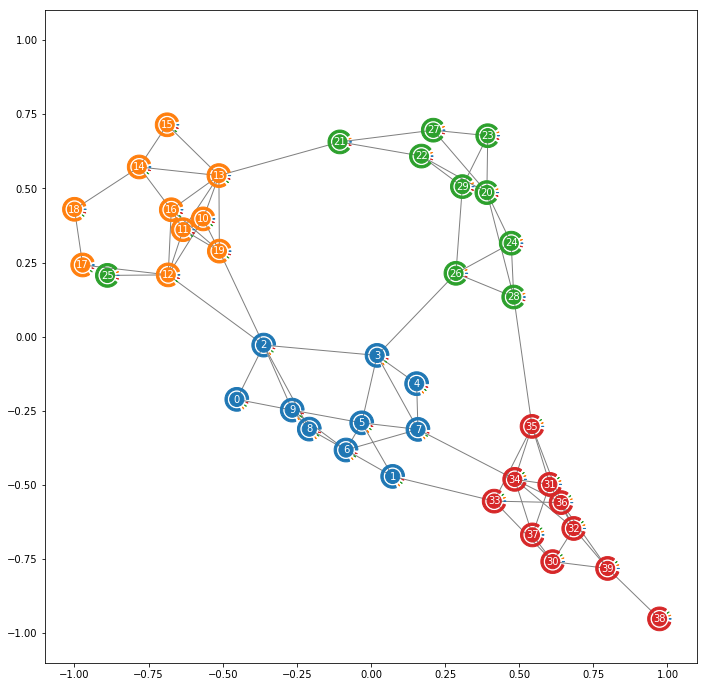

In [42]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [43]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.54826 train_acc=0.12500 val_loss=1.36334 val_acc=0.18750 time=0.03846
Epoch: 0002 train_loss=1.43068 train_acc=0.12500 val_loss=1.27071 val_acc=0.31250 time=0.00229
Epoch: 0003 train_loss=1.32210 train_acc=0.12500 val_loss=1.18768 val_acc=0.46875 time=0.00274
Epoch: 0004 train_loss=1.22301 train_acc=0.50000 val_loss=1.11465 val_acc=0.50000 time=0.00205
Epoch: 0005 train_loss=1.13397 train_acc=0.50000 val_loss=1.05173 val_acc=0.53125 time=0.00351
Epoch: 0006 train_loss=1.05540 train_acc=0.62500 val_loss=0.99872 val_acc=0.56250 time=0.00186
Epoch: 0007 train_loss=0.98706 train_acc=0.62500 val_loss=0.95458 val_acc=0.56250 time=0.00156
Epoch: 0008 train_loss=0.92809 train_acc=0.62500 val_loss=0.91816 val_acc=0.59375 time=0.00155
Epoch: 0009 train_loss=0.87759 train_acc=0.62500 val_loss=0.88822 val_acc=0.59375 time=0.00159
Epoch: 0010 train_loss=0.83454 train_acc=0.62500 val_loss=0.86369 val_acc=0.59375 time=0.00242
Epoch: 0011 train_loss=0.79779 train_acc=0.62500 v

Epoch: 0088 train_loss=0.13350 train_acc=1.00000 val_loss=0.35980 val_acc=0.90625 time=0.00201
Epoch: 0089 train_loss=0.12847 train_acc=1.00000 val_loss=0.35888 val_acc=0.90625 time=0.00150
Epoch: 0090 train_loss=0.12358 train_acc=1.00000 val_loss=0.35807 val_acc=0.90625 time=0.00149
Epoch: 0091 train_loss=0.11881 train_acc=1.00000 val_loss=0.35736 val_acc=0.90625 time=0.00155
Epoch: 0092 train_loss=0.11418 train_acc=1.00000 val_loss=0.35673 val_acc=0.90625 time=0.00185
Epoch: 0093 train_loss=0.10968 train_acc=1.00000 val_loss=0.35620 val_acc=0.90625 time=0.00154
Epoch: 0094 train_loss=0.10532 train_acc=1.00000 val_loss=0.35577 val_acc=0.90625 time=0.00155
Epoch: 0095 train_loss=0.10111 train_acc=1.00000 val_loss=0.35544 val_acc=0.90625 time=0.00147
Epoch: 0096 train_loss=0.09704 train_acc=1.00000 val_loss=0.35522 val_acc=0.90625 time=0.00147
Epoch: 0097 train_loss=0.09313 train_acc=1.00000 val_loss=0.35511 val_acc=0.90625 time=0.00191
Epoch: 0098 train_loss=0.08937 train_acc=1.00000 v

#### Four well-marked communities of size 10; $\sigma = 1$, with 5 samplings

Here, instead of simply using $X_i \sim Y_i + \mathcal{N}(0, \sigma^2)$, we draw 5 such samples for each coordinate in the "real" label $Y_i$:

$$X_{i, 5 \cdot (j-1) + k} = Y_{i, j} + \mathcal{N}(0, \sigma^2) \quad k \in \{1, \dots, 5\}$$

This tests if the GCN can take advantage of the redundancy to recover the communities in spite of the strong noise ($\sigma = 1$).

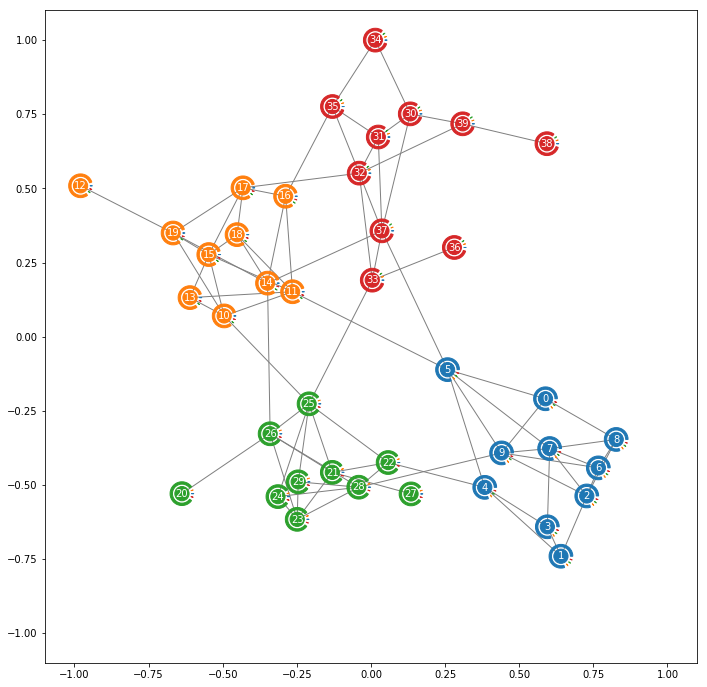

In [48]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 5
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [49]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.44313 train_acc=0.00000 val_loss=1.46650 val_acc=0.15625 time=0.03888
Epoch: 0002 train_loss=1.40965 train_acc=0.00000 val_loss=1.42155 val_acc=0.34375 time=0.00205
Epoch: 0003 train_loss=1.37764 train_acc=0.25000 val_loss=1.37879 val_acc=0.53125 time=0.00182
Epoch: 0004 train_loss=1.34653 train_acc=0.62500 val_loss=1.33861 val_acc=0.56250 time=0.00212
Epoch: 0005 train_loss=1.31669 train_acc=0.62500 val_loss=1.30000 val_acc=0.59375 time=0.00202
Epoch: 0006 train_loss=1.28688 train_acc=0.75000 val_loss=1.26282 val_acc=0.71875 time=0.00179
Epoch: 0007 train_loss=1.25781 train_acc=0.75000 val_loss=1.22622 val_acc=0.81250 time=0.00183
Epoch: 0008 train_loss=1.22822 train_acc=0.75000 val_loss=1.19018 val_acc=0.81250 time=0.00194
Epoch: 0009 train_loss=1.19774 train_acc=0.75000 val_loss=1.15452 val_acc=0.87500 time=0.00217
Epoch: 0010 train_loss=1.16613 train_acc=0.87500 val_loss=1.11893 val_acc=0.90625 time=0.00175
Epoch: 0011 train_loss=1.13346 train_acc=0.87500 v

Epoch: 0088 train_loss=0.03163 train_acc=1.00000 val_loss=0.06650 val_acc=1.00000 time=0.00173
Epoch: 0089 train_loss=0.03058 train_acc=1.00000 val_loss=0.06514 val_acc=1.00000 time=0.00172
Epoch: 0090 train_loss=0.02958 train_acc=1.00000 val_loss=0.06381 val_acc=1.00000 time=0.00184
Epoch: 0091 train_loss=0.02864 train_acc=1.00000 val_loss=0.06253 val_acc=1.00000 time=0.00208
Epoch: 0092 train_loss=0.02774 train_acc=1.00000 val_loss=0.06128 val_acc=1.00000 time=0.00243
Epoch: 0093 train_loss=0.02688 train_acc=1.00000 val_loss=0.06008 val_acc=1.00000 time=0.00170
Epoch: 0094 train_loss=0.02607 train_acc=1.00000 val_loss=0.05893 val_acc=1.00000 time=0.00175
Epoch: 0095 train_loss=0.02530 train_acc=1.00000 val_loss=0.05783 val_acc=1.00000 time=0.00176
Epoch: 0096 train_loss=0.02457 train_acc=1.00000 val_loss=0.05678 val_acc=1.00000 time=0.00177
Epoch: 0097 train_loss=0.02388 train_acc=1.00000 val_loss=0.05577 val_acc=1.00000 time=0.00170
Epoch: 0098 train_loss=0.02322 train_acc=1.00000 v

Epoch: 0175 train_loss=0.00634 train_acc=1.00000 val_loss=0.02700 val_acc=1.00000 time=0.00217
Epoch: 0176 train_loss=0.00627 train_acc=1.00000 val_loss=0.02684 val_acc=1.00000 time=0.00177
Epoch: 0177 train_loss=0.00620 train_acc=1.00000 val_loss=0.02668 val_acc=1.00000 time=0.00347
Epoch: 0178 train_loss=0.00613 train_acc=1.00000 val_loss=0.02653 val_acc=1.00000 time=0.00174
Epoch: 0179 train_loss=0.00606 train_acc=1.00000 val_loss=0.02637 val_acc=1.00000 time=0.00194
Epoch: 0180 train_loss=0.00599 train_acc=1.00000 val_loss=0.02622 val_acc=1.00000 time=0.00581
Epoch: 0181 train_loss=0.00593 train_acc=1.00000 val_loss=0.02607 val_acc=1.00000 time=0.00325
Epoch: 0182 train_loss=0.00586 train_acc=1.00000 val_loss=0.02593 val_acc=1.00000 time=0.00221
Epoch: 0183 train_loss=0.00580 train_acc=1.00000 val_loss=0.02578 val_acc=1.00000 time=0.00167
Epoch: 0184 train_loss=0.00574 train_acc=1.00000 val_loss=0.02564 val_acc=1.00000 time=0.00271
Epoch: 0185 train_loss=0.00567 train_acc=1.00000 v

#### Four well-marked communities of size 10; $\sigma = 100$

TODO: comment

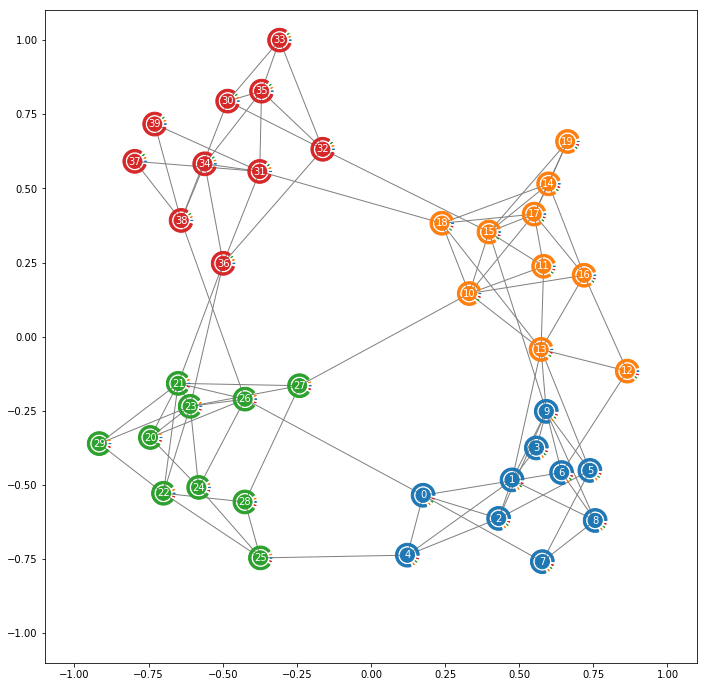

In [52]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 100

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [53]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=2.25628 train_acc=0.25000 val_loss=1.70295 val_acc=0.15625 time=0.04609
Epoch: 0002 train_loss=1.90875 train_acc=0.25000 val_loss=1.48277 val_acc=0.15625 time=0.00215
Epoch: 0003 train_loss=1.58506 train_acc=0.25000 val_loss=1.29791 val_acc=0.15625 time=0.00163
Epoch: 0004 train_loss=1.32047 train_acc=0.25000 val_loss=1.17749 val_acc=0.46875 time=0.00154
Epoch: 0005 train_loss=1.16887 train_acc=0.50000 val_loss=1.12065 val_acc=0.46875 time=0.00156
Epoch: 0006 train_loss=1.12547 train_acc=0.50000 val_loss=1.09434 val_acc=0.43750 time=0.00217
Epoch: 0007 train_loss=1.12431 train_acc=0.50000 val_loss=1.07731 val_acc=0.43750 time=0.00157
Epoch: 0008 train_loss=1.12898 train_acc=0.50000 val_loss=1.06269 val_acc=0.43750 time=0.00196
Epoch: 0009 train_loss=1.12224 train_acc=0.50000 val_loss=1.04643 val_acc=0.46875 time=0.00286
Epoch: 0010 train_loss=1.10737 train_acc=0.50000 val_loss=1.02830 val_acc=0.46875 time=0.00156
Epoch: 0011 train_loss=1.08407 train_acc=0.50000 v

Epoch: 0088 train_loss=0.08365 train_acc=1.00000 val_loss=0.27551 val_acc=0.93750 time=0.00149
Epoch: 0089 train_loss=0.08102 train_acc=1.00000 val_loss=0.27330 val_acc=0.93750 time=0.00154
Epoch: 0090 train_loss=0.07861 train_acc=1.00000 val_loss=0.27097 val_acc=0.93750 time=0.00148
Epoch: 0091 train_loss=0.07631 train_acc=1.00000 val_loss=0.26855 val_acc=0.93750 time=0.00148
Epoch: 0092 train_loss=0.07410 train_acc=1.00000 val_loss=0.26605 val_acc=0.93750 time=0.00155
Epoch: 0093 train_loss=0.07197 train_acc=1.00000 val_loss=0.26351 val_acc=0.93750 time=0.00193
Epoch: 0094 train_loss=0.06993 train_acc=1.00000 val_loss=0.26114 val_acc=0.93750 time=0.00153
Epoch: 0095 train_loss=0.06798 train_acc=1.00000 val_loss=0.25888 val_acc=0.93750 time=0.00171
Epoch: 0096 train_loss=0.06610 train_acc=1.00000 val_loss=0.25675 val_acc=0.93750 time=0.00380
Epoch: 0097 train_loss=0.06430 train_acc=1.00000 val_loss=0.25473 val_acc=0.93750 time=0.00158
Epoch: 0098 train_loss=0.06257 train_acc=1.00000 v

Epoch: 0175 train_loss=0.01587 train_acc=1.00000 val_loss=0.18454 val_acc=0.93750 time=0.00149
Epoch: 0176 train_loss=0.01567 train_acc=1.00000 val_loss=0.18396 val_acc=0.93750 time=0.00150
Epoch: 0177 train_loss=0.01549 train_acc=1.00000 val_loss=0.18340 val_acc=0.93750 time=0.00151
Epoch: 0178 train_loss=0.01530 train_acc=1.00000 val_loss=0.18288 val_acc=0.93750 time=0.00151
Epoch: 0179 train_loss=0.01512 train_acc=1.00000 val_loss=0.18240 val_acc=0.93750 time=0.00149
Epoch: 0180 train_loss=0.01494 train_acc=1.00000 val_loss=0.18195 val_acc=0.93750 time=0.00149
Epoch: 0181 train_loss=0.01476 train_acc=1.00000 val_loss=0.18153 val_acc=0.93750 time=0.00166
Epoch: 0182 train_loss=0.01459 train_acc=1.00000 val_loss=0.18114 val_acc=0.93750 time=0.00149
Epoch: 0183 train_loss=0.01442 train_acc=1.00000 val_loss=0.18078 val_acc=0.93750 time=0.00163
Epoch: 0184 train_loss=0.01426 train_acc=1.00000 val_loss=0.18038 val_acc=0.93750 time=0.00151
Epoch: 0185 train_loss=0.01410 train_acc=1.00000 v

#### Five well-marked communities of size 20; $\sigma = 1$

TODO: comment

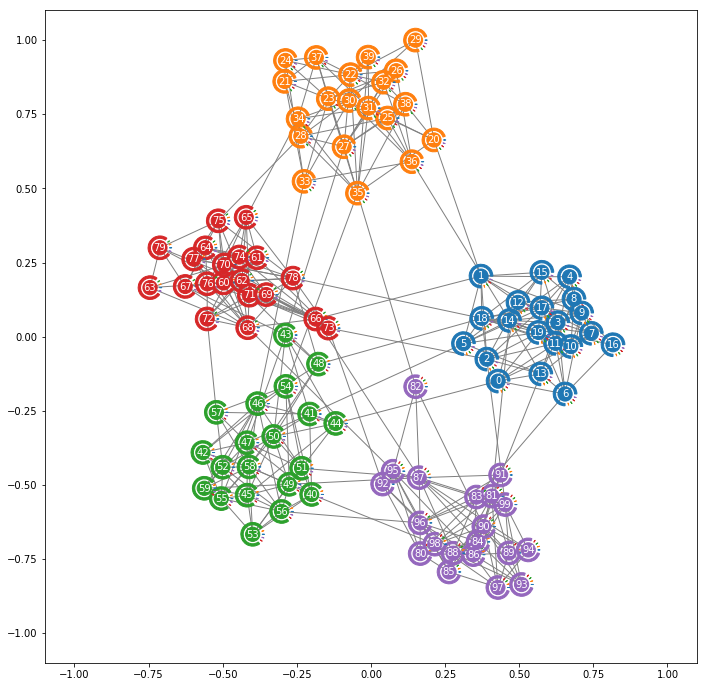

In [54]:
# Parameters
l = 5
k = 20
p_inner = .4
p_outer = .01
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [55]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.77884 train_acc=0.00000 val_loss=1.71781 val_acc=0.02500 time=0.04842
Epoch: 0002 train_loss=1.72151 train_acc=0.00000 val_loss=1.66150 val_acc=0.16250 time=0.00244
Epoch: 0003 train_loss=1.66641 train_acc=0.10000 val_loss=1.60718 val_acc=0.17500 time=0.00230
Epoch: 0004 train_loss=1.61305 train_acc=0.15000 val_loss=1.55416 val_acc=0.18750 time=0.00231
Epoch: 0005 train_loss=1.56081 train_acc=0.25000 val_loss=1.50263 val_acc=0.18750 time=0.00247
Epoch: 0006 train_loss=1.50998 train_acc=0.30000 val_loss=1.45270 val_acc=0.30000 time=0.00418
Epoch: 0007 train_loss=1.46057 train_acc=0.35000 val_loss=1.40460 val_acc=0.43750 time=0.00412
Epoch: 0008 train_loss=1.41291 train_acc=0.40000 val_loss=1.35864 val_acc=0.46250 time=0.00187
Epoch: 0009 train_loss=1.36733 train_acc=0.55000 val_loss=1.31416 val_acc=0.51250 time=0.00190
Epoch: 0010 train_loss=1.32304 train_acc=0.60000 val_loss=1.27103 val_acc=0.56250 time=0.00192
Epoch: 0011 train_loss=1.27984 train_acc=0.60000 v

Epoch: 0088 train_loss=0.05946 train_acc=1.00000 val_loss=0.11192 val_acc=1.00000 time=0.00263
Epoch: 0089 train_loss=0.05734 train_acc=1.00000 val_loss=0.10936 val_acc=1.00000 time=0.00204
Epoch: 0090 train_loss=0.05534 train_acc=1.00000 val_loss=0.10692 val_acc=1.00000 time=0.00193
Epoch: 0091 train_loss=0.05343 train_acc=1.00000 val_loss=0.10459 val_acc=1.00000 time=0.00205
Epoch: 0092 train_loss=0.05164 train_acc=1.00000 val_loss=0.10237 val_acc=1.00000 time=0.00207
Epoch: 0093 train_loss=0.04993 train_acc=1.00000 val_loss=0.10024 val_acc=1.00000 time=0.00199
Epoch: 0094 train_loss=0.04832 train_acc=1.00000 val_loss=0.09821 val_acc=1.00000 time=0.00200
Epoch: 0095 train_loss=0.04678 train_acc=1.00000 val_loss=0.09627 val_acc=1.00000 time=0.00194
Epoch: 0096 train_loss=0.04532 train_acc=1.00000 val_loss=0.09441 val_acc=1.00000 time=0.00200
Epoch: 0097 train_loss=0.04394 train_acc=1.00000 val_loss=0.09263 val_acc=1.00000 time=0.00190
Epoch: 0098 train_loss=0.04262 train_acc=1.00000 v

Epoch: 0175 train_loss=0.01062 train_acc=1.00000 val_loss=0.04436 val_acc=1.00000 time=0.00227
Epoch: 0176 train_loss=0.01050 train_acc=1.00000 val_loss=0.04413 val_acc=1.00000 time=0.00200
Epoch: 0177 train_loss=0.01037 train_acc=1.00000 val_loss=0.04390 val_acc=1.00000 time=0.00248
Epoch: 0178 train_loss=0.01026 train_acc=1.00000 val_loss=0.04368 val_acc=1.00000 time=0.00196
Epoch: 0179 train_loss=0.01014 train_acc=1.00000 val_loss=0.04347 val_acc=1.00000 time=0.00240
Epoch: 0180 train_loss=0.01002 train_acc=1.00000 val_loss=0.04325 val_acc=1.00000 time=0.00252
Epoch: 0181 train_loss=0.00991 train_acc=1.00000 val_loss=0.04304 val_acc=1.00000 time=0.00191
Epoch: 0182 train_loss=0.00980 train_acc=1.00000 val_loss=0.04283 val_acc=1.00000 time=0.00284
Epoch: 0183 train_loss=0.00969 train_acc=1.00000 val_loss=0.04263 val_acc=1.00000 time=0.00244
Epoch: 0184 train_loss=0.00959 train_acc=1.00000 val_loss=0.04243 val_acc=1.00000 time=0.00230
Epoch: 0185 train_loss=0.00948 train_acc=1.00000 v

#### Four poorly-marked communities of size 100; $\sigma = 1$

This is useless as we can't see a thing in the animation, but it was worth a try.

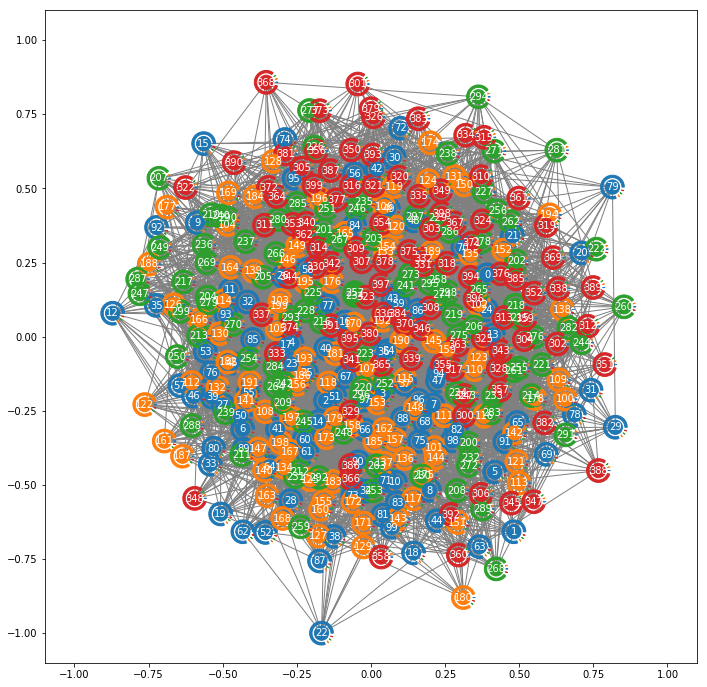

In [56]:
# Parameters
l = 4
k = 100
p_inner = .1
p_outer = .05
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network(g, labels=labels);

In [57]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename, dpi=150)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.45350 train_acc=0.21250 val_loss=1.44877 val_acc=0.20312 time=0.05112
Epoch: 0002 train_loss=1.43741 train_acc=0.21250 val_loss=1.43375 val_acc=0.20312 time=0.00536
Epoch: 0003 train_loss=1.42323 train_acc=0.21250 val_loss=1.42084 val_acc=0.20000 time=0.00536
Epoch: 0004 train_loss=1.41093 train_acc=0.21250 val_loss=1.40986 val_acc=0.20312 time=0.00463
Epoch: 0005 train_loss=1.40033 train_acc=0.21250 val_loss=1.40062 val_acc=0.20625 time=0.00551
Epoch: 0006 train_loss=1.39115 train_acc=0.23750 val_loss=1.39284 val_acc=0.22813 time=0.00488
Epoch: 0007 train_loss=1.38316 train_acc=0.27500 val_loss=1.38631 val_acc=0.26875 time=0.00501
Epoch: 0008 train_loss=1.37621 train_acc=0.32500 val_loss=1.38084 val_acc=0.28438 time=0.00451
Epoch: 0009 train_loss=1.37012 train_acc=0.31250 val_loss=1.37617 val_acc=0.28438 time=0.00483
Epoch: 0010 train_loss=1.36465 train_acc=0.35000 val_loss=1.37210 val_acc=0.28125 time=0.00559
Epoch: 0011 train_loss=1.35968 train_acc=0.33750 v

Epoch: 0088 train_loss=1.09013 train_acc=0.50000 val_loss=1.18065 val_acc=0.49687 time=0.00581
Epoch: 0089 train_loss=1.08758 train_acc=0.50000 val_loss=1.17958 val_acc=0.49687 time=0.00596
Epoch: 0090 train_loss=1.08514 train_acc=0.50000 val_loss=1.17853 val_acc=0.49375 time=0.00475
Epoch: 0091 train_loss=1.08273 train_acc=0.50000 val_loss=1.17754 val_acc=0.49375 time=0.00613
Epoch: 0092 train_loss=1.08037 train_acc=0.50000 val_loss=1.17662 val_acc=0.49375 time=0.00519
Epoch: 0093 train_loss=1.07807 train_acc=0.50000 val_loss=1.17575 val_acc=0.49687 time=0.00566
Epoch: 0094 train_loss=1.07580 train_acc=0.50000 val_loss=1.17495 val_acc=0.49687 time=0.00476
Epoch: 0095 train_loss=1.07357 train_acc=0.51250 val_loss=1.17420 val_acc=0.49687 time=0.00542
Epoch: 0096 train_loss=1.07137 train_acc=0.51250 val_loss=1.17346 val_acc=0.49687 time=0.00450
Epoch: 0097 train_loss=1.06920 train_acc=0.51250 val_loss=1.17274 val_acc=0.49687 time=0.00531
Epoch: 0098 train_loss=1.06707 train_acc=0.51250 v